In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward
import mplhep as hep
import glob
hep.style.use("CMS")

In [43]:
#Building some variables
def DeltaPhi(row, col1, col2 = 'met_Phi'):
    """
    correction on azimuthal angle difference dphi
    """
    dphi = row[col1] - row[col2]
    if dphi >= np.pi: 
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi

    return dphi

def transverse_mass(l_pt, met_et, deltaphi):
    #Calculates the transverse mass between lepton and the met
    return np.sqrt(2 * l_pt * met_et * (1 - np.cos(deltaphi)))

def invariant_mass(obj1_pt, obj1_eta, obj2_pt, obj2_eta, deltaphi ):
    #Calculates the invariant mass for 2 different objects
    return np.sqrt(2 * obj1_pt * obj2_pt * (np.cosh(obj1_eta-obj2_eta) - np.cos(deltaphi)))

def delta_eta(eta1, eta2):
    #Calculates the absolute value of the delta eta among two objects 
    return np.abs(eta1-eta2)

def OneTaggedAnalyzer(row, coltag, colpt, coleta, colphi, colmass):
    """
    Getting info from a set of 4 jets on a tagged object, this function assumes only one object tagged
    """
    Tag_pT = 0; Tag_eta = 0; Tag_phi = 0; Tag_m = 0
    for i in range(len(coltag)):
        Tag_pT+=(np.nan_to_num(row[coltag[i]], copy=False)*row[colpt[i]])
        Tag_eta+=(np.nan_to_num(row[coltag[i]], copy=False)*row[coleta[i]])
        Tag_phi+=(np.nan_to_num(row[coltag[i]], copy=False)*row[colphi[i]])
        Tag_m+=(np.nan_to_num(row[coltag[i]], copy=False)*row[colmass[i]])

    return Tag_pT, Tag_eta, Tag_phi, Tag_m

def OneTaggedAnalyzerPT(row, coltag, colpt, coleta, colphi, colmass):
    """
    Getting info from a set of 4 jets on a tagged object, this function assumes only one object tagged
    """
    Tag_pT = 0
    for i in range(len(coltag)): Tag_pT+=(np.nan_to_num(row[coltag[i]], copy=False)*row[colpt[i]])

    return Tag_pT

def OneTaggedAnalyzerETA(row, coltag, colpt, coleta, colphi, colmass):
    """
    Getting info from a set of 4 jets on a tagged object, this function assumes only one object tagged
    """
    Tag_eta = 0
    for i in range(len(coltag)): Tag_eta+=(np.nan_to_num(row[coltag[i]], copy=False)*row[coleta[i]])

    return Tag_eta

def OneTaggedAnalyzerPHI(row, coltag, colpt, coleta, colphi, colmass):
    """
    Getting info from a set of 4 jets on a tagged object, this function assumes only one object tagged
    """
    Tag_phi = 0
    for i in range(len(coltag)): Tag_phi+=(np.nan_to_num(row[coltag[i]], copy=False)*row[colphi[i]])

    return Tag_phi

def OneTaggedAnalyzerM(row, coltag, colpt, coleta, colphi, colmass):
    """
    Getting info from a set of 4 jets on a tagged object, this function assumes only one object tagged
    """
    Tag_m = 0
    for i in range(len(coltag)): Tag_m+=(np.nan_to_num(row[coltag[i]], copy=False)*row[colmass[i]])

    return Tag_m


In [48]:
#Base selection
def simple_cut(df, branch, Ctype = ">", val = 0):
    if Ctype==">": mask = (df[branch] > val)
    elif Ctype=="<": mask = (df[branch] < val)
    elif Ctype=="==": mask = (df[branch] == val)
    return df.loc[mask]

def eta_cut(df, branch, Ctype = ">", val = 2.4):
    if Ctype==">": mask = np.abs(df[branch]) > val
    elif Ctype=="<": mask = np.abs(df[branch]) < val
    return df.loc[mask]

def basic_mu_cuts(df, n_tau = 2, pt_j = 30, met = 50, n_mu = 1, pt_mu = 25):
    """
    Returns a copy of the df filtered by different variables and different objects
    Parameters:
        df : A Pandas.Dataframe to be filtered. This DataFrame must have a series of columns named as 
             missinget_met,missinget_phi,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,jet_eta3,
             jet_phi0,jet_phi1,jet_phi2,jet_phi3,jet_mass0,jet_mass1,jet_mass2,jet_mass3,
             jet_tautag0,jet_tautag1,jet_tautag2,jet_tautag3,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_size,
             electron_pt0,electron_pt1,electron_eta0,electron_eta1,electron_phi0,electron_phi1,electron_charge0,electron_charge1,electron_size,
             muon_pt0,muon_pt1,muon_eta0,muon_eta1,muon_phi0,muon_phi1,muon_charge0,muon_charge1,muon_size,n_b,n_tau
    """
    cut_df = df.copy()
    cut_df = simple_cut(cut_df, "n_tau", Ctype = "<", val = n_tau)
    cut_df = simple_cut(cut_df, "muon_size", Ctype = ">", val = n_mu-1)
    cut_df = simple_cut(cut_df, "muon_pt0", val = pt_mu)
    cut_df = simple_cut(cut_df, "missinget_met", val = met)
    cut_df = simple_cut(cut_df, "jet_pt0", val = pt_j)
    cut_df = simple_cut(cut_df, "jet_pt1", val = pt_j)
    cut_df['Delta_phi_mu_Met'] = cut_df.apply(DeltaPhi,axis = 1, args=('muon_phi0', 'missinget_phi'))
    return cut_df

def basic_allch_cuts(df, n_j = 2, pt_j = 30, n_b = 0, met = 50, n_tau = 2, n_e = 1, n_mu = 1, pt_tau = 25, pt_e = 25, pt_mu = 25):
    """
    Returns a copy of the df filtered by different variables and different objects
    Parameters:
        df : A Pandas.Dataframe to be filtered. This DataFrame must have a series of columns named as 
             missinget_met,missinget_phi,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,jet_eta3,
             jet_phi0,jet_phi1,jet_phi2,jet_phi3,jet_mass0,jet_mass1,jet_mass2,jet_mass3,
             jet_tautag0,jet_tautag1,jet_tautag2,jet_tautag3,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_size,
             electron_pt0,electron_pt1,electron_eta0,electron_eta1,electron_phi0,electron_phi1,electron_charge0,electron_charge1,electron_size,
             muon_pt0,muon_pt1,muon_eta0,muon_eta1,muon_phi0,muon_phi1,muon_charge0,muon_charge1,muon_size,n_b,n_tau
    """
    cut_df = df.copy()
    cut_df = simple_cut(cut_df, "jet_size", Ctype = ">", val = n_j)
    cut_df = simple_cut(cut_df, "jet_pt0", val = pt_j)
    cut_df = simple_cut(cut_df, "jet_pt1", val = pt_j)
    cut_df['Delta_phi_j0_j1'] = cut_df.apply(DeltaPhi,axis = 1, args=('jet_phi0', 'jet_phi1'))
    cut_df = simple_cut(cut_df, "missinget_met", val = met)
    #cut_df = simple_cut(cut_df, "n_tau", Ctype = "==", val = n_tau)
    NTaus_mask=(cut_df.jet_tautag0.replace(np.nan, 0)+cut_df.jet_tautag1.replace(np.nan, 0)+cut_df.jet_tautag2.replace(np.nan, 0)+cut_df.jet_tautag3.replace(np.nan, 0)) == n_tau
    cut_df.loc[NTaus_mask]
    if n_tau == 1: 
        #Falta escpger los dos jets mas energeticos diferentes al tautag 
        tautag=["jet_tautag0","jet_tautag1","jet_tautag2","jet_tautag3"]
        jpt=["jet_pt0","jet_pt1","jet_pt2","jet_pt3"]
        jeta=["jet_eta0","jet_eta1","jet_eta2","jet_eta3"]
        jphi=["jet_phi0","jet_phi1","jet_phi2","jet_phi3"]
        jmass=["jet_mass0","jet_mass1","jet_mass2","jet_mass3"]
        cut_df['tau_pt0'] = cut_df.apply(OneTaggedAnalyzerPT,axis = 1, args=(tautag, jpt, jeta, jphi, jmass))
        cut_df['tau_eta0'] = cut_df.apply(OneTaggedAnalyzerETA,axis = 1, args=(tautag, jpt, jeta, jphi, jmass))
        cut_df['tau_phi0'] = cut_df.apply(OneTaggedAnalyzerPHI,axis = 1, args=(tautag, jpt, jeta, jphi, jmass))
        cut_df['tau_mass0'] = cut_df.apply(OneTaggedAnalyzerM,axis = 1, args=(tautag, jpt, jeta, jphi, jmass))
        #Tauprop = cut_df.apply(OneTaggedAnalyzer,axis = 1, args=(tautag, jpt, jeta, jphi, jmass))
        #cut_df['tau_pt0'] = Tauprop[0]; cut_df['tau_eta0'] = Tauprop[1]
        #cut_df['tau_phi0'] = Tauprop[2]; cut_df['tau_mass0'] = Tauprop[3]
        cut_df = simple_cut(cut_df, "tau_pt0", val = pt_tau)
        cut_df['Delta_phi_tau_Met'] = cut_df.apply(DeltaPhi,axis = 1, args=('tau_phi0', 'missinget_phi'))
    Nb_mask=(cut_df.jet_btag0.replace(np.nan, 0)+cut_df.jet_btag1.replace(np.nan, 0)+cut_df.jet_btag2.replace(np.nan, 0)+cut_df.jet_btag3.replace(np.nan, 0)) == n_b
    cut_df.loc[Nb_mask]
    cut_df = simple_cut(cut_df, "electron_size", Ctype = "==", val = n_e)
    cut_df = simple_cut(cut_df, "muon_size", Ctype = "==", val = n_mu)
    if n_mu == 1: 
        cut_df = simple_cut(cut_df, "muon_pt0", val = pt_mu)
        cut_df['Delta_phi_mu_Met'] = cut_df.apply(DeltaPhi,axis = 1, args=('muon_phi0', 'missinget_phi'))
    if n_e == 1: 
        cut_df = simple_cut(cut_df, "electron_pt0", val = pt_e)
        cut_df['Delta_phi_e_Met'] = cut_df.apply(DeltaPhi,axis = 1, args=('electron_phi0', 'missinget_phi'))
    return cut_df

In [53]:
def plot_var(dfs, var, binmin, binmax, steps, labelsc, colorsc, xlabelc, size, labs_sizes = 20):

    """
    Returns a 1 dimentional array with 6 histograms in 2 axis with the information of 
    missing energy in the transverse plane and the angle phi in that plane.
    Parameters:
        dfs : List of dataframes.
        var : Variable to be plotted.
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
    """
    
    fig, axs = plt.subplots(1, 1, figsize = (6, 6), constrained_layout=True)

    bins1 = np.linspace(binmin,binmax,steps)
    histo=[]; binshisto=[]
    for i in range(len(dfs)):
        tmphisto, tmpbins = np.histogram(dfs[i][var], bins1)
        hep.histplot(tmphisto,
                 bins = tmpbins,
                 density = True,
                 ax = axs,
                 histtype='step',
                 color = colorsc[i],
                 label = labelsc[i])
        histo.append(tmphisto); binshisto.append(tmpbins)

    axs.legend(loc = 'best', fontsize = size)
    axs.set_ylabel("a.u.", fontsize = labs_sizes)
    axs.set_xlabel(xlabelc, fontsize = labs_sizes)
    axs.set_title(r'$(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)

    #return histo, binshisto

def plot_ser(ser, binmin, binmax, steps, labelsc, colorsc, xlabelc, size, labs_sizes = 20):

    """
    Returns a 1 dimentional array with 6 histograms in 2 axis with the information of 
    missing energy in the transverse plane and the angle phi in that plane.
    Parameters:
        dfs : List of dataframes.
        var : Variable to be plotted.
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
    """

    fig, axs = plt.subplots(1, 1, figsize = (6, 6), constrained_layout=True)

    bins1 = np.linspace(binmin,binmax,steps)
    histo=[]; binshisto=[]
    for i in range(len(ser)):
        tmphisto, tmpbins = np.histogram(ser[i], bins1)
        hep.histplot(tmphisto,
                 bins = tmpbins,
                 density = True,
                 ax = axs,
                 histtype='step',
                 color = colorsc[i],
                 label = labelsc[i])
        histo.append(tmphisto); binshisto.append(tmpbins)

    axs.legend(loc = 'best', fontsize = size)
    axs.set_ylabel("a.u.", fontsize = labs_sizes)
    axs.set_xlabel(xlabelc, fontsize = labs_sizes)
    axs.set_title(r'$(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)

    #return histo, binshisto

#Crazy ploltter
def crazy_plotter(dfs,part,index,labelsc,colorsc):
    if part=="muon": texc=r"\mu"
    if part=="electron": texc=r"e"
    if part=="tau": texc=r"\tau_{h}"
    if part=="jet": texc=r"j_{"+index+"}"
    plot_var(dfs, part+"_pt"+index, 0, 1000, 60,labelsc, colorsc, r"$p_T("+texc+")$ [GeV]", size = 14)
    plot_var(dfs, part+"_phi"+index, -4, 4, 40, labelsc, colorsc, r"$\phi("+texc+")$", size = 14)
    if part=="muon" or part=="electron":
        plot_var(dfs, part+"_charge"+index, -2, 2, 5, labelsc, colorsc, r"$Charge("+texc+")$", size = 14)
        plot_var(dfs, part+"_eta"+index, -3, 3, 60,labelsc, colorsc, r"$\eta("+texc+")$", size = 14)
    if part=="jet" or part=="tau":
        plot_var(dfs, part+"_mass"+index, 0, 200, 40, labelsc, colorsc, r"$m("+texc+")$ [GeV]", size = 14)
        plot_var(dfs, part+"_eta"+index, -5, 5, 50,labelsc, colorsc, r"$\eta("+texc+")$", size = 14)

In [5]:
Z1_df = pd.read_csv("../Wprime_VBF_gWWpZ1.csv")
Z1_df_After_Cleansing = basic_mu_cuts(Z1_df)
Z1_df_After_Cleansing['Delta_phi_j0_j1'] = Z1_df_After_Cleansing.apply(DeltaPhi,axis = 1, args=('jet_phi0', 'jet_phi1'))
Z1_df_After_Cleansing['Delta_phi_mu_met'] = Z1_df_After_Cleansing.apply(DeltaPhi,axis = 1, args=('muon_phi0', 'missinget_phi'))

A1_df = pd.read_csv("../Wprime_VBF_gWWpA1.csv")
A1_df_After_Cleansing = basic_mu_cuts(A1_df)
A1_df_After_Cleansing['Delta_phi_j0_j1'] = A1_df_After_Cleansing.apply(DeltaPhi,axis = 1, args=('jet_phi0', 'jet_phi1'))
A1_df_After_Cleansing['Delta_phi_mu_met'] = A1_df_After_Cleansing.apply(DeltaPhi,axis = 1, args=('muon_phi0', 'missinget_phi'))

Z2_df = pd.read_csv("../Wprime_VBF_gWWpZ2.csv")
Z2_df_After_Cleansing = basic_mu_cuts(Z2_df)
Z2_df_After_Cleansing['Delta_phi_j0_j1'] = Z2_df_After_Cleansing.apply(DeltaPhi,axis = 1, args=('jet_phi0', 'jet_phi1'))
Z2_df_After_Cleansing['Delta_phi_mu_met'] = Z2_df_After_Cleansing.apply(DeltaPhi,axis = 1, args=('muon_phi0', 'missinget_phi'))

A2_df = pd.read_csv("../Wprime_VBF_gWWpA2.csv")
A2_df_After_Cleansing = basic_mu_cuts(A2_df)
A2_df_After_Cleansing['Delta_phi_j0_j1'] = A2_df_After_Cleansing.apply(DeltaPhi,axis = 1, args=('jet_phi0', 'jet_phi1'))
A2_df_After_Cleansing['Delta_phi_mu_met'] = A2_df_After_Cleansing.apply(DeltaPhi,axis = 1, args=('muon_phi0', 'missinget_phi'))


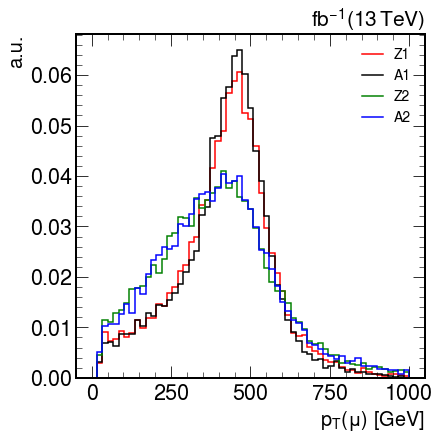

In [6]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "muon_pt0", 0, 1000, 60, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$p_T(\mu)$ [GeV]", size = 14)

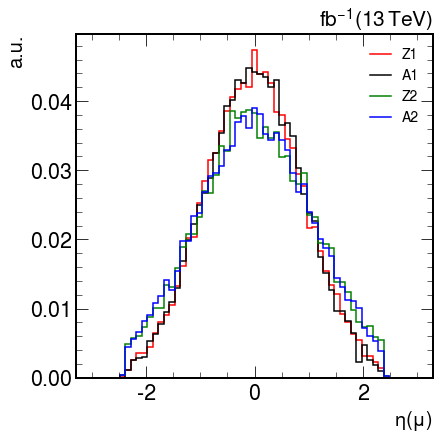

In [7]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "muon_eta0", -3, 3, 60, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\eta(\mu)$", size = 14)

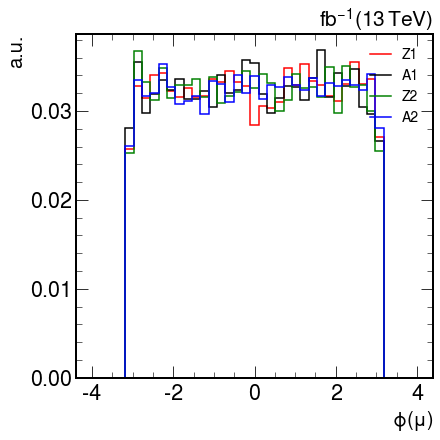

In [8]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "muon_phi0", -4, 4, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\phi(\mu)$", size = 14)

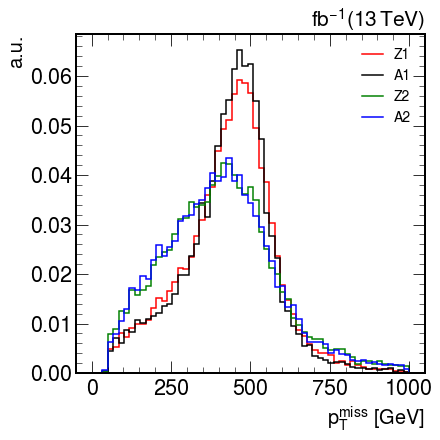

In [9]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "missinget_met", 0, 1000, 60, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$p_T^{miss}$ [GeV]", size = 14)

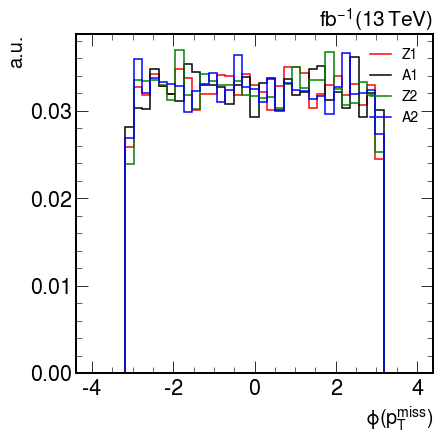

In [10]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "missinget_phi", -4, 4, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\phi(p_T^{miss})$", size = 14)

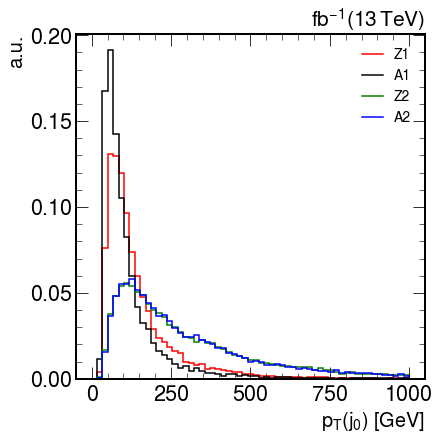

In [11]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "jet_pt0", 0, 1000, 60, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$p_T(j_{0})$ [GeV]", size = 14)

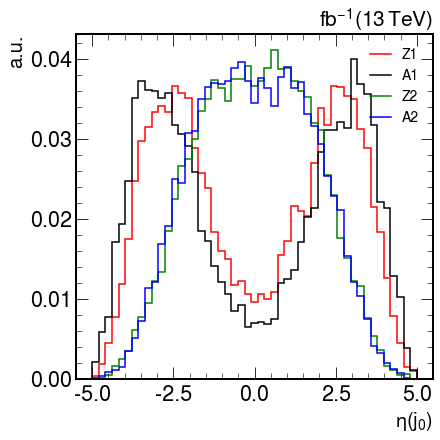

In [12]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "jet_eta0", -5, 5, 50, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\eta(j_{0})$", size = 14)

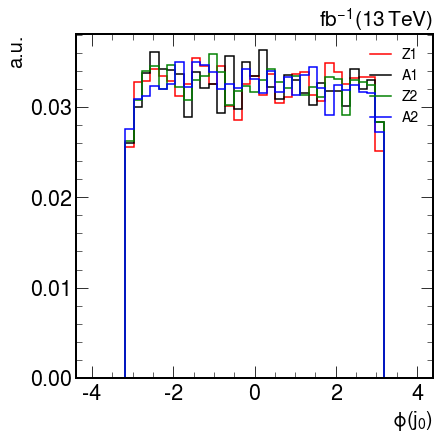

In [13]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "jet_phi0", -4, 4, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\phi(j_{0})$", size = 14)

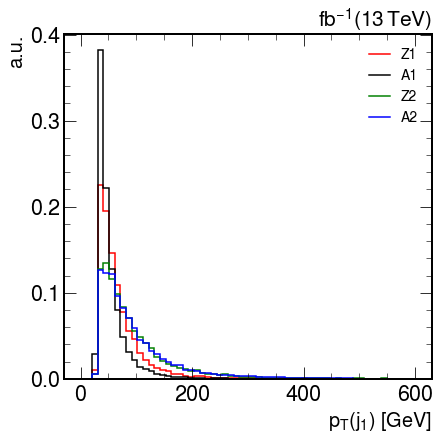

In [14]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "jet_pt1", 0, 600, 60, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$p_T(j_{1})$ [GeV]", size = 14)

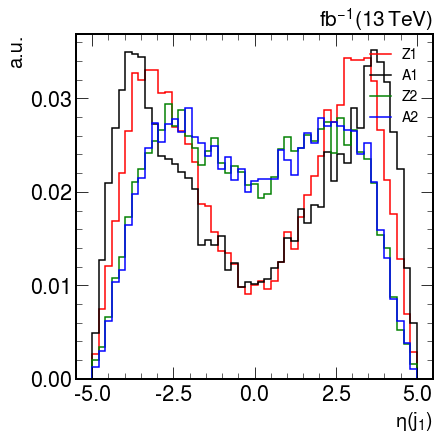

In [15]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "jet_eta1", -5, 5, 50, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\eta(j_{1})$", size = 14)

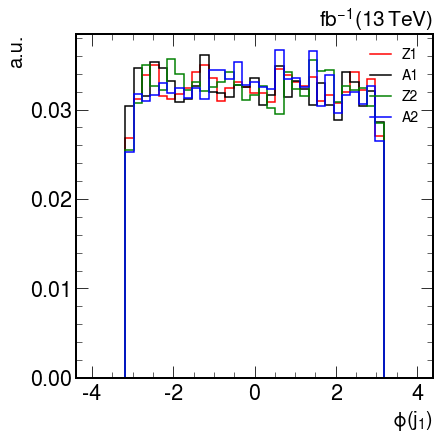

In [16]:
plot_var([Z1_df_After_Cleansing, A1_df_After_Cleansing, Z2_df_After_Cleansing, A2_df_After_Cleansing], 
        "jet_phi1", -4, 4, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\phi(j_{1})$", size = 14)

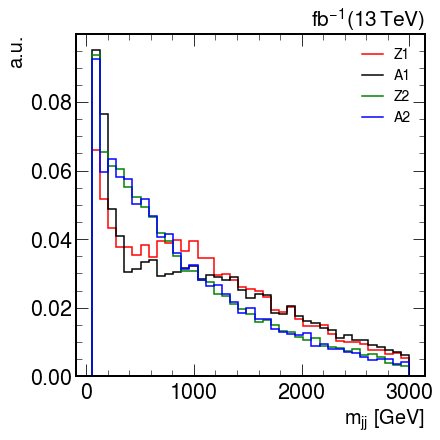

In [17]:
m_jj_Z1 = invariant_mass(Z1_df_After_Cleansing.jet_pt0, Z1_df_After_Cleansing.jet_eta0, Z1_df_After_Cleansing.jet_pt1, Z1_df_After_Cleansing.jet_eta1, Z1_df_After_Cleansing.Delta_phi_j0_j1 )
m_jj_A1 = invariant_mass(A1_df_After_Cleansing.jet_pt0, A1_df_After_Cleansing.jet_eta0, A1_df_After_Cleansing.jet_pt1, A1_df_After_Cleansing.jet_eta1, A1_df_After_Cleansing.Delta_phi_j0_j1 )
m_jj_Z2 = invariant_mass(Z2_df_After_Cleansing.jet_pt0, Z2_df_After_Cleansing.jet_eta0, Z2_df_After_Cleansing.jet_pt1, Z2_df_After_Cleansing.jet_eta1, Z2_df_After_Cleansing.Delta_phi_j0_j1 )
m_jj_A2 = invariant_mass(A2_df_After_Cleansing.jet_pt0, A2_df_After_Cleansing.jet_eta0, A2_df_After_Cleansing.jet_pt1, A2_df_After_Cleansing.jet_eta1, A2_df_After_Cleansing.Delta_phi_j0_j1 )

plot_ser([m_jj_Z1,m_jj_A1,m_jj_Z2,m_jj_A2], 50, 3000, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$m_{jj}$ [GeV]", size = 14)


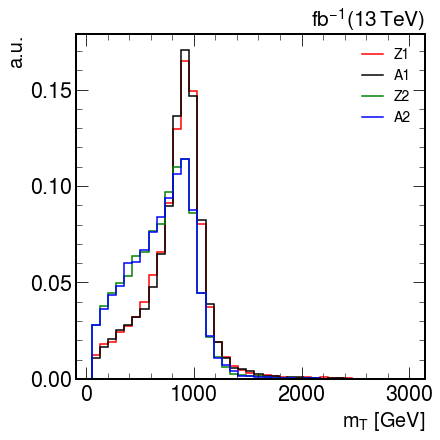

In [18]:
m_T_Z1 = transverse_mass(Z1_df_After_Cleansing.muon_pt0, Z1_df_After_Cleansing.missinget_met, Z1_df_After_Cleansing.Delta_phi_mu_met)
m_T_A1 = transverse_mass(A1_df_After_Cleansing.muon_pt0, A1_df_After_Cleansing.missinget_met, A1_df_After_Cleansing.Delta_phi_mu_met)
m_T_Z2 = transverse_mass(Z2_df_After_Cleansing.muon_pt0, Z2_df_After_Cleansing.missinget_met, Z2_df_After_Cleansing.Delta_phi_mu_met)
m_T_A2 = transverse_mass(A2_df_After_Cleansing.muon_pt0, A2_df_After_Cleansing.missinget_met, A2_df_After_Cleansing.Delta_phi_mu_met)

plot_ser([m_T_Z1,m_T_A1,m_T_Z2,m_T_A2], 50, 3000, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$m_{T}$ [GeV]", size = 14)

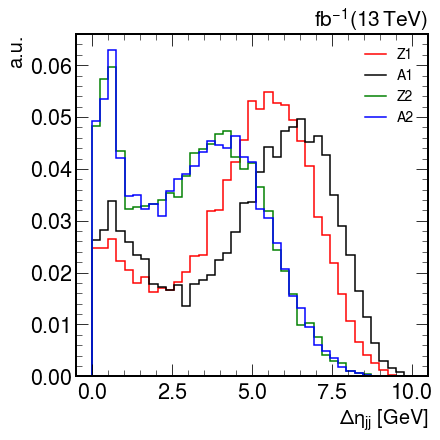

In [19]:
Delta_eta_Z1 = delta_eta(Z1_df_After_Cleansing.jet_eta0, Z1_df_After_Cleansing.jet_eta1)
Delta_eta_A1 = delta_eta(A1_df_After_Cleansing.jet_eta0, A1_df_After_Cleansing.jet_eta1)
Delta_eta_Z2 = delta_eta(Z2_df_After_Cleansing.jet_eta0, Z2_df_After_Cleansing.jet_eta1)
Delta_eta_A2 = delta_eta(A2_df_After_Cleansing.jet_eta0, A2_df_After_Cleansing.jet_eta1)

plot_ser([Delta_eta_Z1,Delta_eta_A1,Delta_eta_Z2,Delta_eta_A2], 0, 10, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\Delta\eta_{jj}$ [GeV]", size = 14)

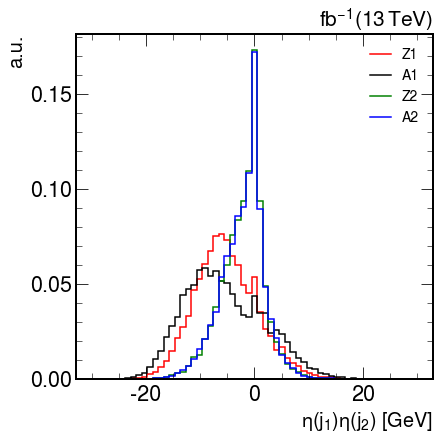

In [20]:
Mul_eta_Z1 = Z1_df_After_Cleansing.jet_eta0*Z1_df_After_Cleansing.jet_eta1
Mul_eta_A1 = A1_df_After_Cleansing.jet_eta0*A1_df_After_Cleansing.jet_eta1
Mul_eta_Z2 = Z2_df_After_Cleansing.jet_eta0*Z2_df_After_Cleansing.jet_eta1
Mul_eta_A2 = A2_df_After_Cleansing.jet_eta0*A2_df_After_Cleansing.jet_eta1

plot_ser([Mul_eta_Z1,Mul_eta_A1,Mul_eta_Z2,Mul_eta_A2], -30, 30, 60, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\eta(j_{1})\eta(j_{2})$ [GeV]", size = 14)

# Muon Channel

In [21]:
Z1_df_mu = basic_allch_cuts(Z1_df, n_j = 2, pt_j = 60, n_b = 0, met = 50, n_tau = 0, n_e = 0, n_mu = 1, pt_mu = 25)
A1_df_mu = basic_allch_cuts(A1_df, n_j = 2, pt_j = 60, n_b = 0, met = 50, n_tau = 0, n_e = 0, n_mu = 1, pt_mu = 25)
Z2_df_mu = basic_allch_cuts(Z2_df, n_j = 2, pt_j = 60, n_b = 0, met = 50, n_tau = 0, n_e = 0, n_mu = 1, pt_mu = 25)
A2_df_mu = basic_allch_cuts(A2_df, n_j = 2, pt_j = 60, n_b = 0, met = 50, n_tau = 0, n_e = 0, n_mu = 1, pt_mu = 25)


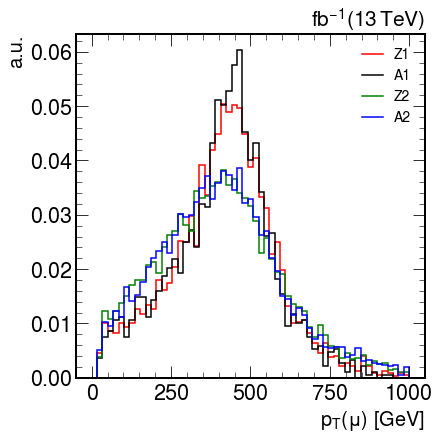

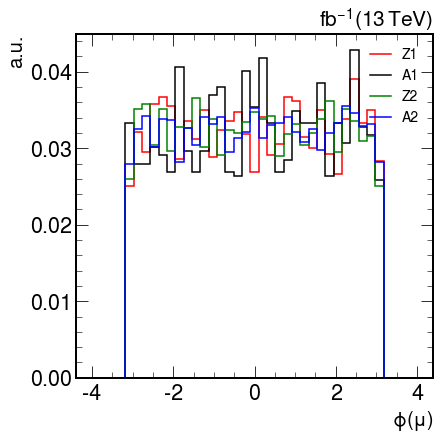

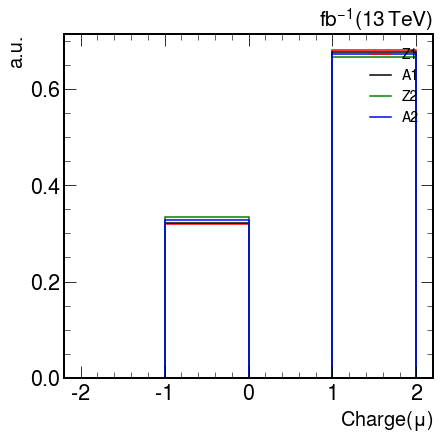

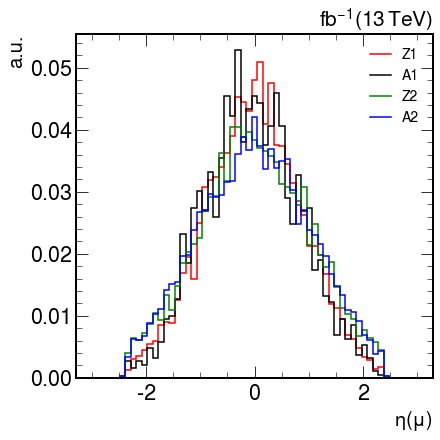

In [22]:
crazy_plotter([Z1_df_mu, A1_df_mu, Z2_df_mu, A2_df_mu],"muon","0",["Z1","A1","Z2","A2"],["r","k","g","b"])

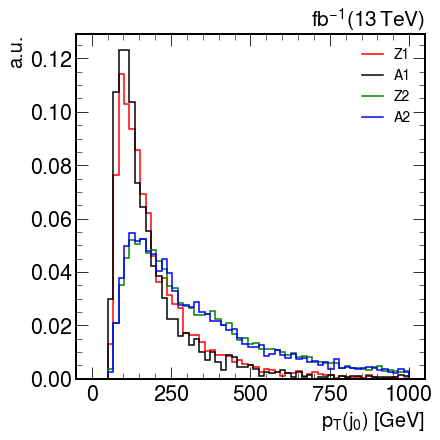

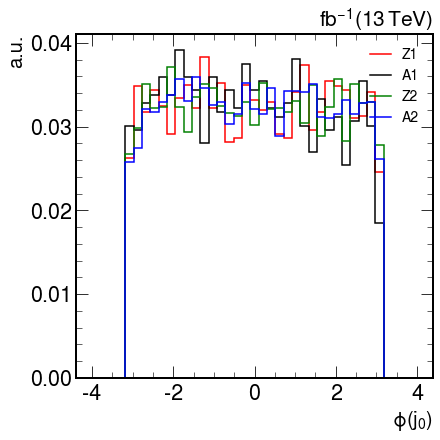

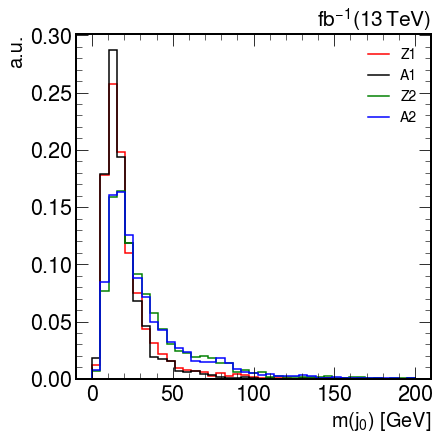

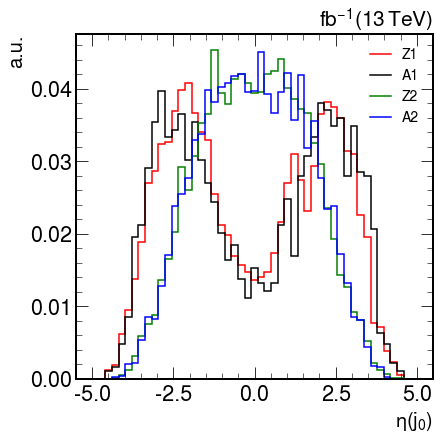

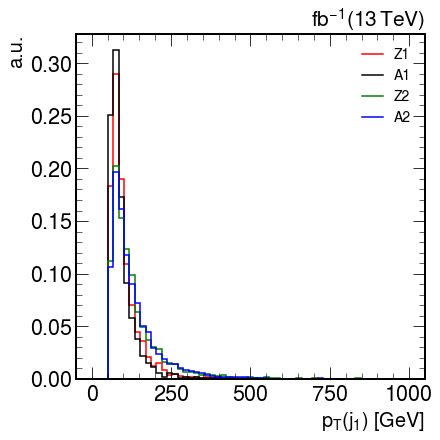

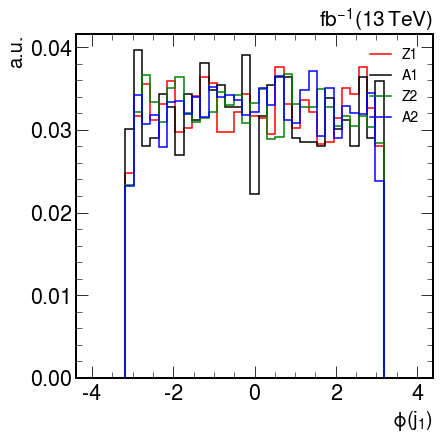

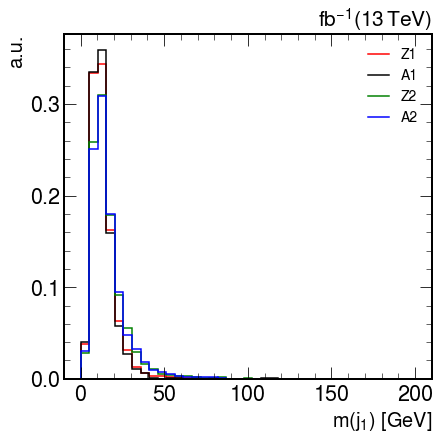

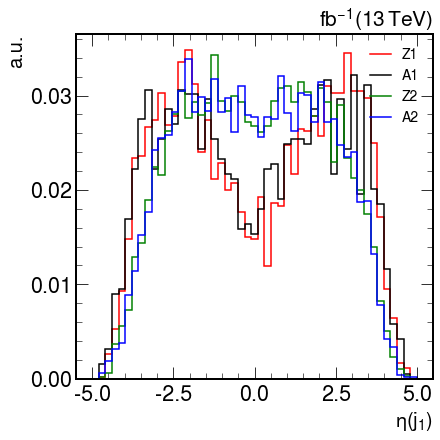

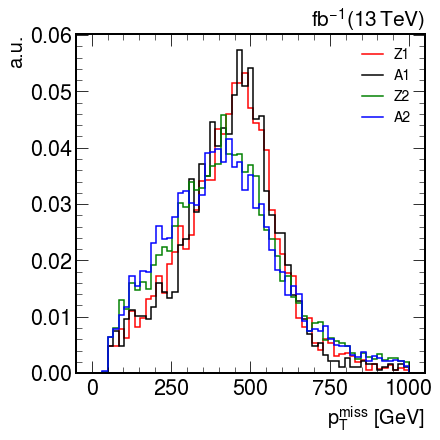

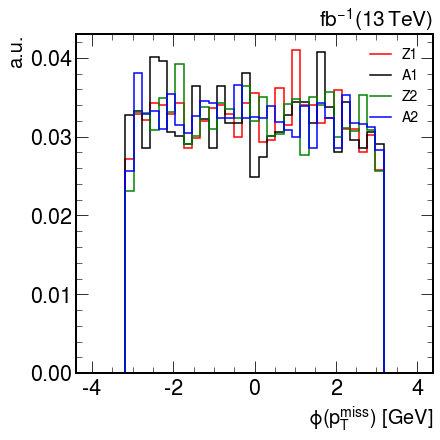

In [23]:
crazy_plotter([Z1_df_mu, A1_df_mu, Z2_df_mu, A2_df_mu],"jet","0",["Z1","A1","Z2","A2"],["r","k","g","b"])
crazy_plotter([Z1_df_mu, A1_df_mu, Z2_df_mu, A2_df_mu],"jet","1",["Z1","A1","Z2","A2"],["r","k","g","b"])
plot_var([Z1_df_mu, A1_df_mu, Z2_df_mu, A2_df_mu], 
        "missinget_met", 0, 1000, 60, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$p_T^{miss}$ [GeV]", size = 14)
plot_var([Z1_df_mu, A1_df_mu, Z2_df_mu, A2_df_mu], 
        "missinget_phi", -4, 4, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\phi(p_T^{miss})$ [GeV]", size = 14)

# Electron Channel

In [24]:
Z1_df_e = basic_allch_cuts(Z1_df, n_j = 2, pt_j = 60, n_b = 0, met = 50, n_tau = 0, n_e = 1, n_mu = 0, pt_e = 25)
A1_df_e = basic_allch_cuts(A1_df, n_j = 2, pt_j = 60, n_b = 0, met = 50, n_tau = 0, n_e = 1, n_mu = 0, pt_e = 25)
Z2_df_e = basic_allch_cuts(Z2_df, n_j = 2, pt_j = 60, n_b = 0, met = 50, n_tau = 0, n_e = 1, n_mu = 0, pt_e = 25)
A2_df_e = basic_allch_cuts(A2_df, n_j = 2, pt_j = 60, n_b = 0, met = 50, n_tau = 0, n_e = 1, n_mu = 0, pt_e = 25)

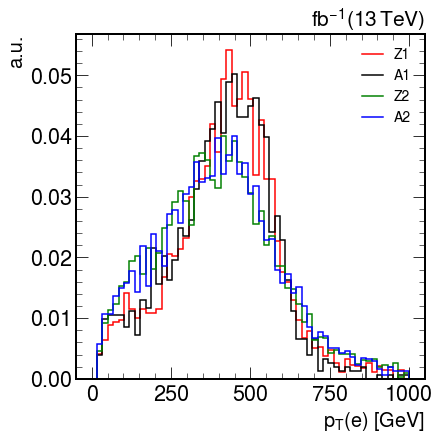

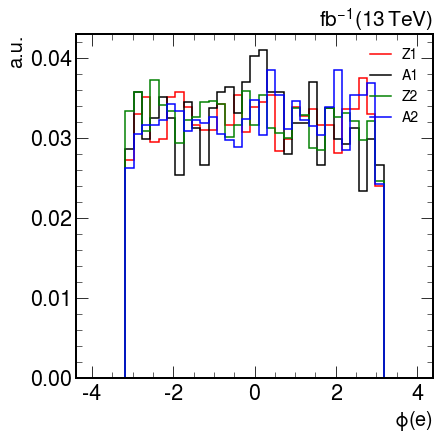

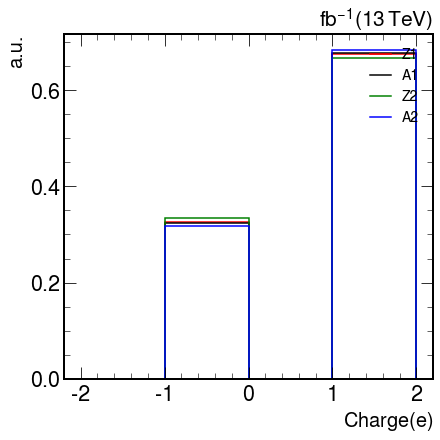

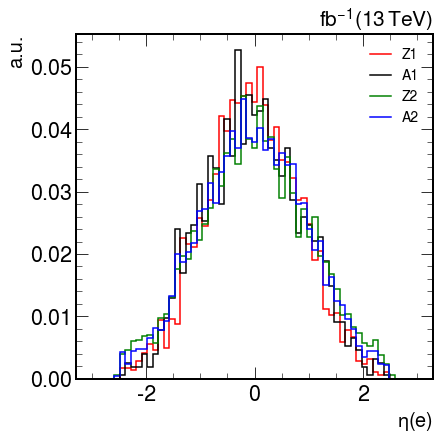

In [25]:
crazy_plotter([Z1_df_e, A1_df_e, Z2_df_e, A2_df_e],"electron","0",["Z1","A1","Z2","A2"],["r","k","g","b"])

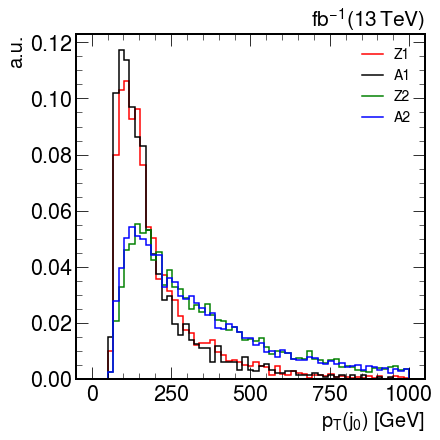

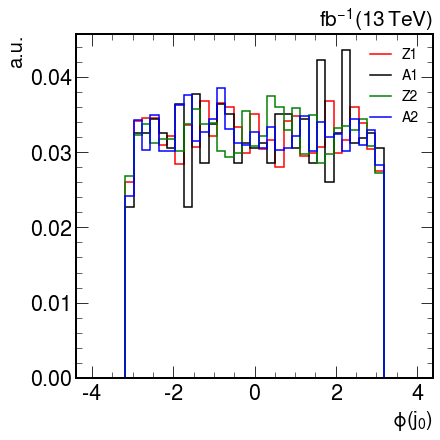

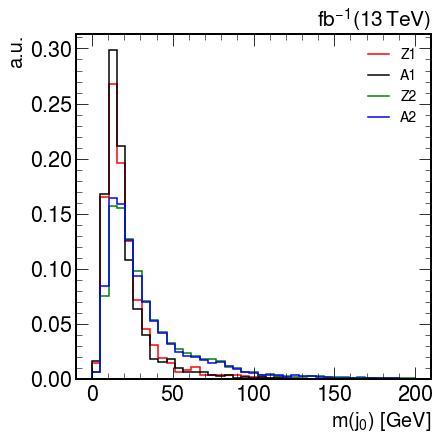

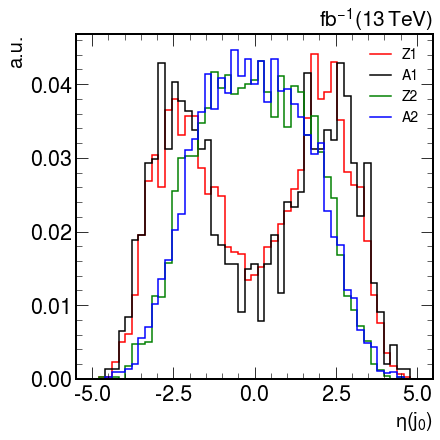

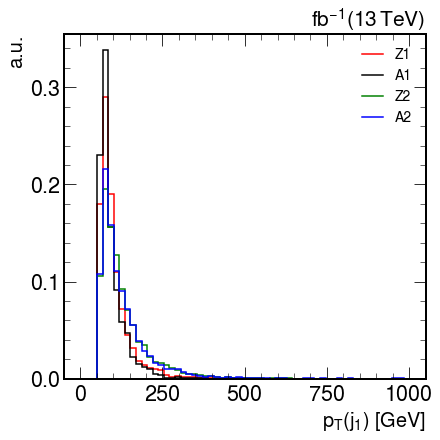

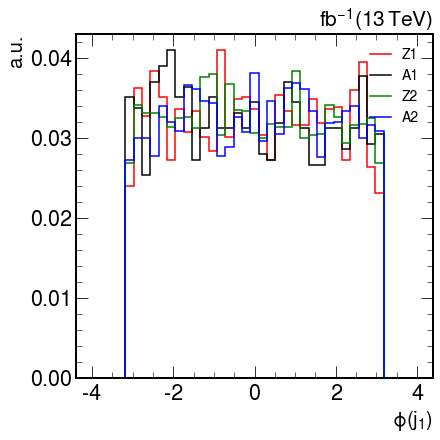

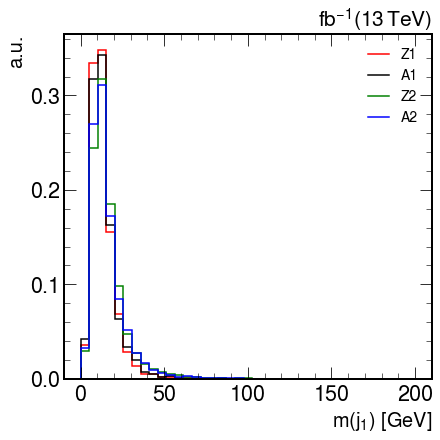

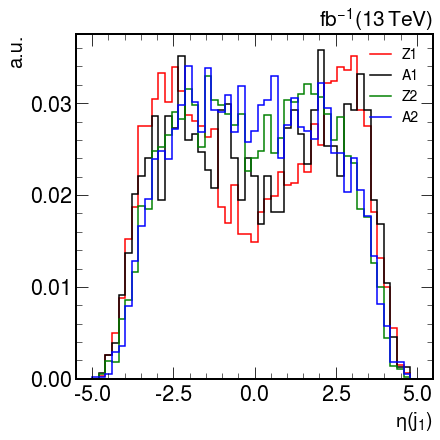

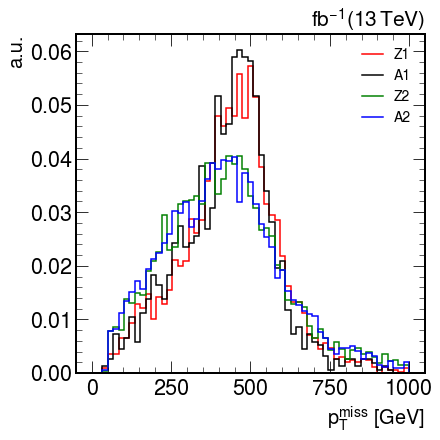

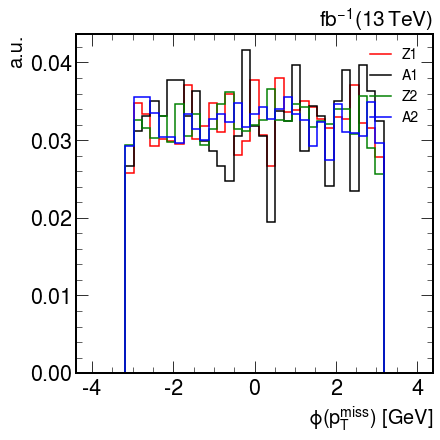

In [26]:
crazy_plotter([Z1_df_e, A1_df_e, Z2_df_e, A2_df_e],"jet","0",["Z1","A1","Z2","A2"],["r","k","g","b"])
crazy_plotter([Z1_df_e, A1_df_e, Z2_df_e, A2_df_e],"jet","1",["Z1","A1","Z2","A2"],["r","k","g","b"])
plot_var([Z1_df_e, A1_df_e, Z2_df_e, A2_df_e], 
        "missinget_met", 0, 1000, 60, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$p_T^{miss}$ [GeV]", size = 14)
plot_var([Z1_df_e, A1_df_e, Z2_df_e, A2_df_e], 
        "missinget_phi", -4, 4, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\phi(p_T^{miss})$ [GeV]", size = 14)

# Tau channel

In [49]:
Z1_df_tau = basic_allch_cuts(Z1_df, n_j = 3, pt_j = 60, n_b = 0, met = 50, n_tau = 1, n_e = 0, n_mu = 0, pt_tau = 25)
A1_df_tau = basic_allch_cuts(A1_df, n_j = 3, pt_j = 60, n_b = 0, met = 50, n_tau = 1, n_e = 0, n_mu = 0, pt_tau = 25)
Z2_df_tau = basic_allch_cuts(Z2_df, n_j = 3, pt_j = 60, n_b = 0, met = 50, n_tau = 1, n_e = 0, n_mu = 0, pt_tau = 25)
A2_df_tau = basic_allch_cuts(A2_df, n_j = 3, pt_j = 60, n_b = 0, met = 50, n_tau = 1, n_e = 0, n_mu = 0, pt_tau = 25)

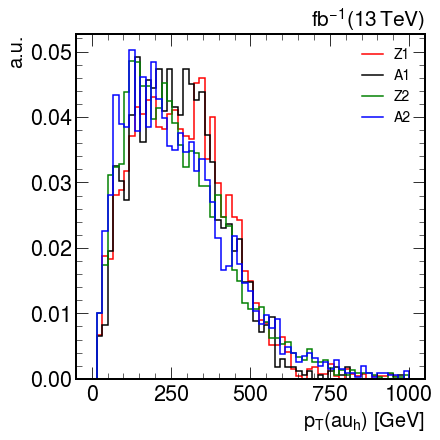

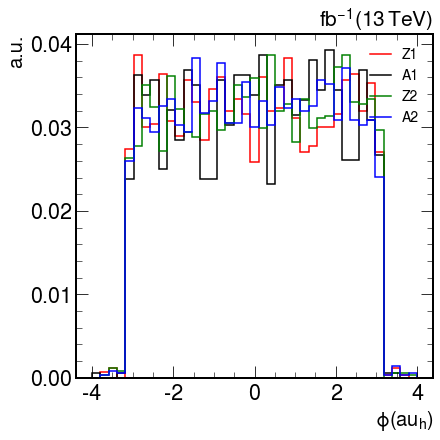

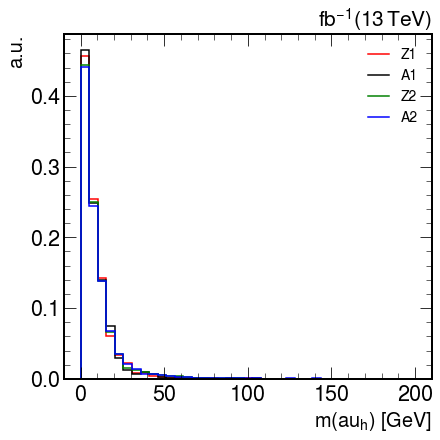

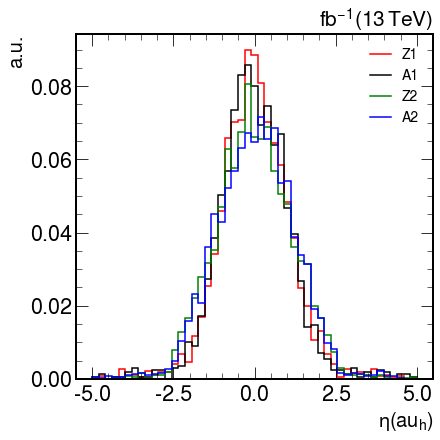

In [50]:
crazy_plotter([Z1_df_tau, A1_df_tau, Z2_df_tau, A2_df_tau],"tau","0",["Z1","A1","Z2","A2"],["r","k","g","b"])

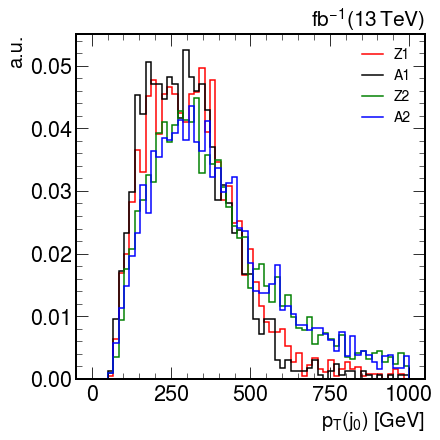

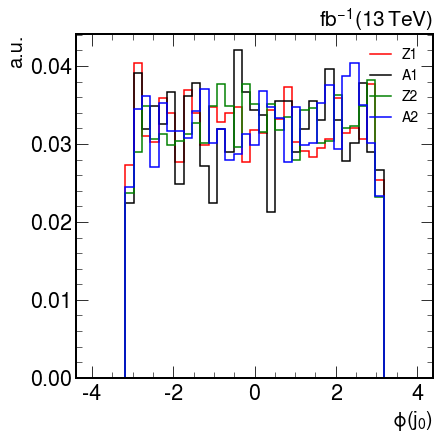

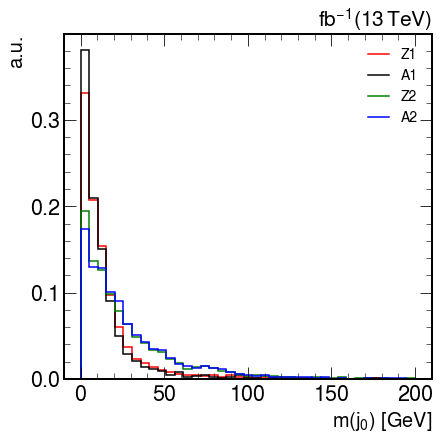

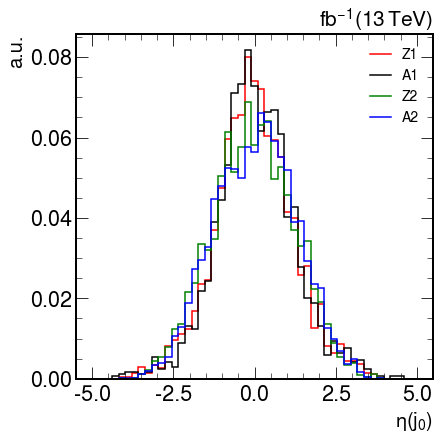

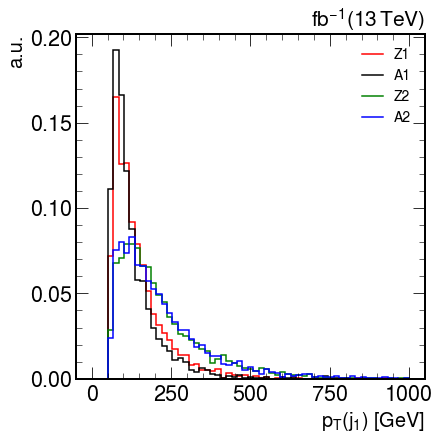

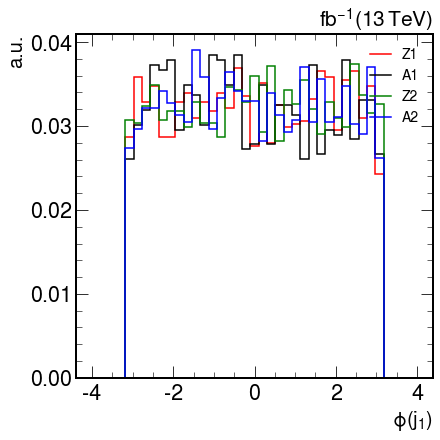

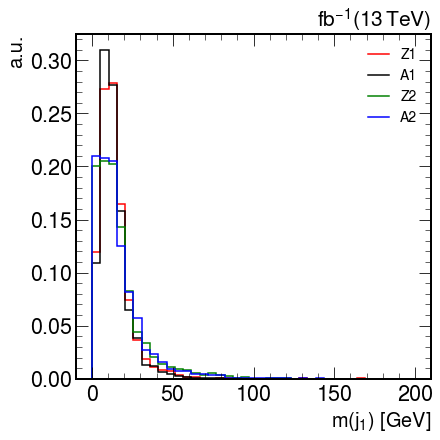

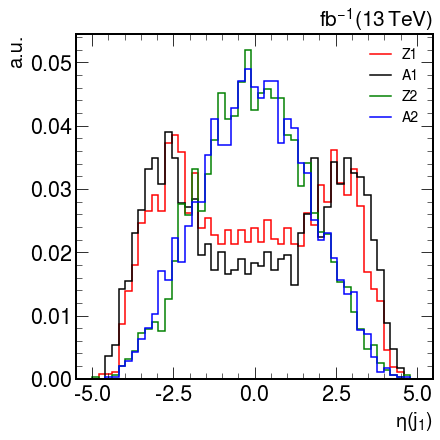

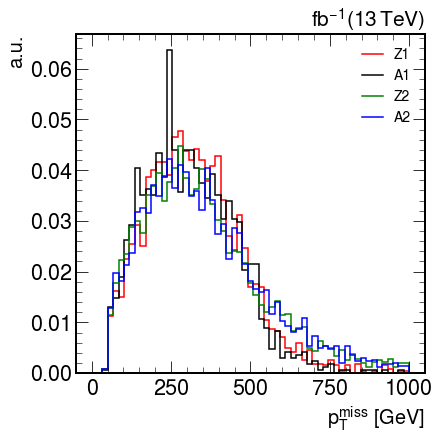

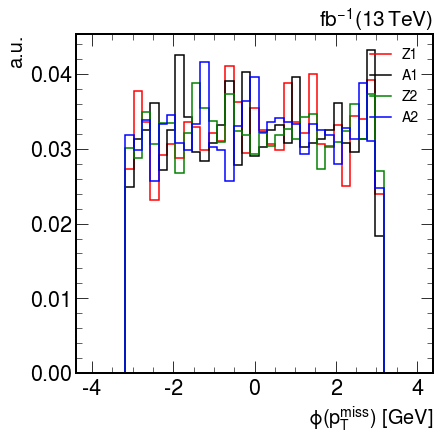

In [51]:
crazy_plotter([Z1_df_tau, A1_df_tau, Z2_df_tau, A2_df_tau],"jet","0",["Z1","A1","Z2","A2"],["r","k","g","b"])
crazy_plotter([Z1_df_tau, A1_df_tau, Z2_df_tau, A2_df_tau],"jet","1",["Z1","A1","Z2","A2"],["r","k","g","b"])
plot_var([Z1_df_tau, A1_df_tau, Z2_df_tau, A2_df_tau], 
        "missinget_met", 0, 1000, 60, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$p_T^{miss}$ [GeV]", size = 14)
plot_var([Z1_df_tau, A1_df_tau, Z2_df_tau, A2_df_tau], 
        "missinget_phi", -4, 4, 40, ["Z1","A1","Z2","A2"], ["r","k","g","b"], r"$\phi(p_T^{miss})$ [GeV]", size = 14)